In [11]:
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd

from matplotlib import animation as ani
#from JSAnimation import IPython_display

[1, 1.0] [1, 8.0710678118654755] [1, -6.0710678118654755]


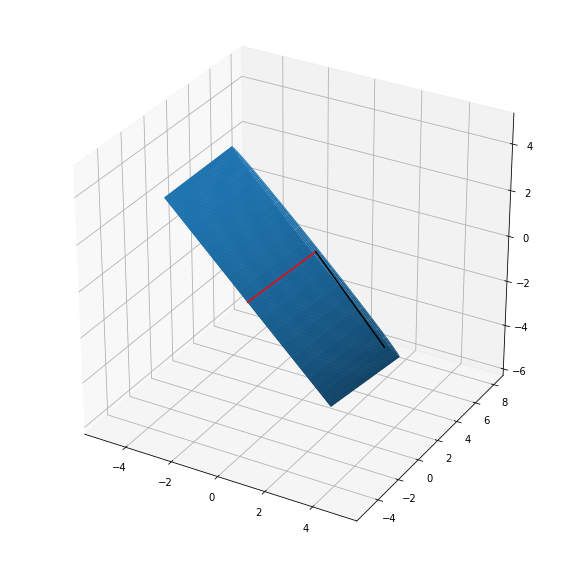

In [2]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
origin = np.array([0, 0, 0])
#axis and radius
p0 = np.array([-1, -1, -1])
p1 = np.array([1, 1, 1])
R = 5
#vector in direction of axis
v = p1 - p0
#find magnitude of vector
mag = norm(v)
#unit vector in direction of axis
v = v / mag
#make some vector not in the same direction as v
not_v = np.array([1, 0, 0])
if (v == not_v).all():
    not_v = np.array([0, 1, 0])
#make vector perpendicular to v
n1 = np.cross(v, not_v)
#normalize n1
n1 /= norm(n1)
#make unit vector perpendicular to v and n1
n2 = np.cross(v, n1)
#surface ranges over t from 0 to length of axis and 0 to 2*pi
t = np.linspace(0, mag, 100)
theta = np.linspace(0, 2 * np.pi, 100)
#use meshgrid to make 2d arrays
t, theta = np.meshgrid(t, theta)
#generate coordinates for surface
X, Y, Z = [p0[i] + v[i] * t + R * np.sin(theta) * n1[i] + R * np.cos(theta) * n2[i] for i in [0, 1, 2]]
ax.plot_surface(X, Y, Z)
#plot axis
ax.plot(*zip(p0, p1), color = 'red')
ax.plot([p1[0],p1[0]+n1[0]*10],[p1[1],p1[1]+n1[1]*10],[p1[2],p1[2]+n1[2]*10],color='k')
print([p1[0],p1[0]+n1[0]*10],[p1[1],p1[1]+n1[1]*10],[p1[2],p1[2]+n1[2]*10])
plt.show()

In [3]:
print(p0,p1)
print(mag)
print(v)
print(not_v)
print(n1)
print(n2)

[-1 -1 -1] [1 1 1]
3.46410161514
[ 0.57735027  0.57735027  0.57735027]
[1 0 0]
[ 0.          0.70710678 -0.70710678]
[-0.81649658  0.40824829  0.40824829]


In [156]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r,phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

class OVec(object):
    a = np.r_[0,0,0]
    b = np.r_[0,0,0]
    c = np.r_[0,0,0]
    V = np.r_[0,0,0]
    uV = np.r_[0,0,0]
    mV = 0
    def __init__(self,x0=0,y0=0,z0=0,x1=0,y1=0,z1=0):
        
        self.setup(x0,y0,z0,x1,y1,z1)
        
    def setup(self,x0,y0,z0,x1,y1,z1):
        
        self.a = np.r_[x0,y0,z0]
        self.b = np.r_[x1,y1,z1]
        
        self.centroid()
        self.vec()
        self.mag()
        self.unit()
        
    def centroid(self):
        self.c = (self.a + self.b)/2
        
    def vec(self):
        self.V = self.b - self.a
        
    def mag(self):
        self.mV = np.sqrt(np.sum(pow(self.V,2)))
    
    def unit(self):
        self.uV = self.V/self.mV
    
    def crossv(self,v):
        return self.V[0]*v.V[0] + self.V[1]*v.V[1]+self.V[2]*v.V[2]
    
    def projv(self, v):
        x = self.crossv(V)/(v.mV**2)
        b = np.r_[0,0,0]
        b[0] = v.b[0]*x
        b[1] = v.b[1]*x
        b[2] = v.b[2]*x
        vt = OVec(*v.a,*b)
        return vt
    
    def projp(self, v):
        vt = self.projv(v)
        a = self.V - vt.V
        vn = OVec(*vt.b,*a)
        return vn
        

In [165]:


sin = np.sin
cos = np.cos

class OWave(object):
    kx = None
    Eta = None
    Theta = None;
    def __init__(self):
        
        pass
        
    def calc(self, t,om,amp,eps,k,x,y,Ek):
        
        self.wave_plane(k,x,y,Ek)
        self.wave_phase(om,t,eps)
        self.wave_profile(amp)
        
    def wave_plane(self,k,x,y,Ek):
        
        self.kx = k  * x * Ek[0] + k * y * Ek[1];
        return self.kx;

    def wave_phase(self, om, t, eps ):
        self.Theta = self.kx - om * t - eps;
        return self.Theta;
    
    def wave_profile(self,amp):
        self.Eta = amp * np.cos( self.Theta );
        return self.Eta;

class OParticle(object):
    uah = None
    uav = None
    dotuah = None
    dotuav = None
    ddotuah = None
    ddotuav = None
    
    u = OVec()
    dotu = OVec()
    ddotu = OVec()
        
    def __init__(self,om,amp,k,z,draft0):
        
        self.excursion_amplitude(amp,k,z,draft0);
        self.velocity_amplitude(om);
        self.accleration_amplitude(om)
        
    def excursion_amplitude(self, amp, k, z,  draft0):
        #//if z = xc : draft0 = 0, else draft0>0
        self.uah = amp * np.cosh(k * (z -draft0 + depth)) / np.sinh(k*depth); #//hor
        self.uav = amp * np.sinh(k * (z -draft0 + depth)) / np.sinh(k*depth);# //vert
        return self.uah, self.uav

    def velocity_amplitude(self,om):
        self.dotuah = om * self.uah;#//hor
        self.dotuav = om * self.uav;#//ver
        return self.dotuah, self.dotuav

    def accleration_amplitude(self,om):
        self.ddotuah = om * self.dotuah;#//h
        self.ddotuav = om * self.dotuav;#//v
        return self.ddotuah, self.ddotuav

    def calc(self,Theta,Ek, x, y,z):
        
        return self.excursion(Theta, Ek,x,y,z), \
               self.velocity(Theta, Ek,x,y,z), \
               self.acceleration(Theta, Ek,x,y,z)
    
    def excursion(self, Theta, Ek,x,y,z):

        ux = -Ek[0] * self.uah * sin(Theta);#//x
        uy = -Ek[1] * self.uah * sin(Theta);#//y
        uz = self.uav * cos(Theta);#//v
        
        self.u = OVec(x,y,z,ux,uy,uz)
        
        return self.u

    def velocity(self, Theta, Ek,x,y,z):
        dotux = Ek[0] * self.dotuah * cos(Theta);#//x
        dotuy = Ek[1] * self.dotuah * cos(Theta);#//y
        dotuz = self.dotuav * sin(Theta);#//z
        
        self.dotu = OVec(x,y,z,dotux,dotuy,dotuz)
        
        return self.dotu

    def acceleration( self,Theta, Ek,x,y,z):
        ddotux = Ek[0] * self.ddotuah * sin(Theta);#//x
        ddotuy = Ek[1] * self.ddotuah * sin(Theta);#//y
        ddotuz = -self.ddotuav * cos(Theta);#//z
        self.ddotu = OVec(x,y,z,ddotux,ddotuy,ddotuz)

        return self.ddotu

def rotx(x,y,a):
    return x*cos(-a)+y*sin(-a)
def roty(x,y,a):
    return y*cos(-a)-x*sin(-a)
    



/home/robgrzel/.conda/envs/py36a/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [182]:
T = 3
om = 2*np.pi/T
k = om**2/9.81

alpha = np.deg2rad(30)
Ek = [np.cos(alpha),np.sin(alpha)]

eps = 0
amp = 1

z0 = 0;
draft0 = 0;
depth = 50;
t = 0.5

o = np.r_[0, 0, 0]

d = 20

bounds = np.c_[
    [-d,-d,0],
    [-d,d,0],
    [d,d,0],
    [d,-d,0],
]

x = np.linspace(-d,d,30)
y = np.linspace(-d,d,30)
z = np.zeros(x.shape)
X,Y = np.meshgrid(x,y)

IC = []

cords = np.c_[
    [-8,-8,-10,-12,-12,10],
    [-8,8,-10,-12,12,10],
    [8,-8,-10,12,-12,10],
    [8,8,-10,12,12,10],
].T

for i in range(len(cords)):
    print(cords[i])
    IC.append(OVec(*cords[i]))
    
cordsc = [ic.c for ic in IC]
cordsc = np.c_[cordsc]

xc,yc,zc = cordsc.T
Xc,Yc = np.meshgrid(xc,yc)


[ -8  -8 -10 -12 -12  10]
[ -8   8 -10 -12  12  10]
[  8  -8 -10  12 -12  10]
[  8   8 -10  12  12  10]


<IPython.core.display.Javascript object>


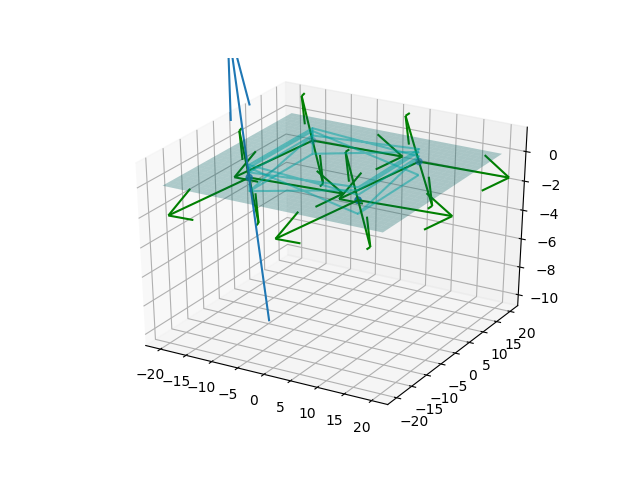

In [194]:
W = OWave();

P = OParticle(om,amp,k,z0,draft0);

shape1 = (xc.size,yc.size)
shape2 = (x.size,y.size)

Eta1 = np.zeros(shape1)
Eta2 = np.zeros(shape2)
U = np.zeros(shape1,dtype=OVec)
dotU = U.copy()
ddotU = U.copy()

i=0
for xi in xc:
    j=0
    for yi in yc:
        Eta2[i,j]=W.Eta

i=0
for xi in xc:
    j=0
    for yi in yc:
        W.calc( t,om,amp,eps,k,xi,yi,Ek)
        P.calc(W.Theta,Ek, xi, yi,0)
        Eta1[i,j]=W.Eta
        U[i,j] = P.u;
        dotU[i,j] = P.dotu;
        ddotU[i,j] = P.ddotu;
        j+=1
    i+=1
    
plt.figure()
ax = plt.gca(projection='3d')
ax.plot_surface(X,Y,z,color='c',alpha=0.3)
ax.plot_wireframe(Xc,Yc,Eta,color='c',alpha=0.5)
ax.scatter(xc,yc,zc,'ko')
ax.quiver(*IC[0].a,*IC[0].V)
for i in range(shape[0]):
    for j in range(shape[1]):
        #ax.quiver(Xc[i,j],Yc[i,j],0,*U[i,j].V,color='r')
        ax.quiver(Xc[i,j],Yc[i,j],0,*dotU[i,j].V,color='g')
        #ax.quiver(Xc[i,j],Yc[i,j],0,*ddotU[i,j].V,color='m')
plt.show()

[ 10. -10. -10.  10.]
[ 10. -10.  10. -10.]


<IPython.core.display.Javascript object>


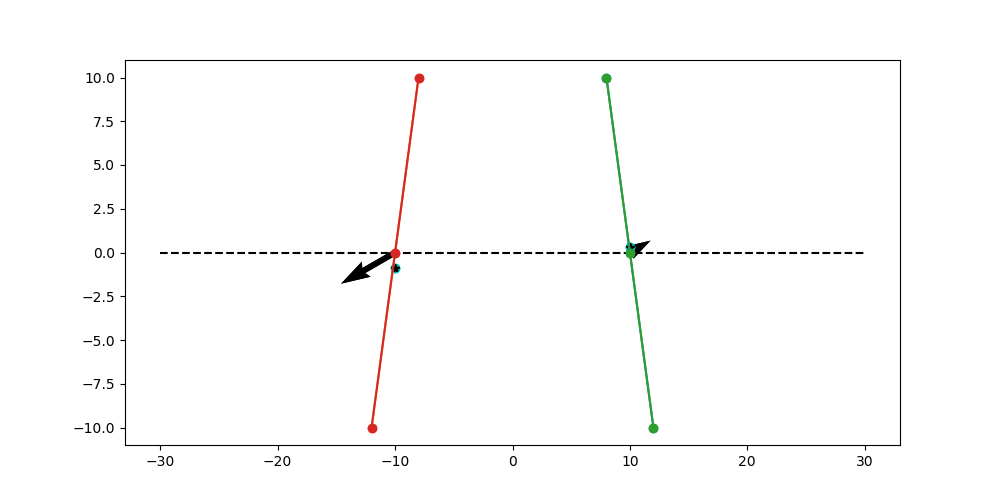

In [130]:

X,Y = np.meshgrid(x,y)
Xc,Yc = np.meshgrid(xc,yc)
Oc = np.zeros(Xc.shape)

if 1:
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(xc,Eta[:,0],'co',linewidth=5)
    plt.plot(xc,U[:,0,2],'k*')
    plt.quiver(xc,Oc[:,0],dotU[:,0,0],dotU[:,0,1])
    
    #plt.plot(x,U[0][:,0],'r.')
    #plt.plot(x,U[0][:,2],'g.')
    plt.plot([-d,d],[0,0],'k--')
    for i in range(4):
        plt.plot(*zip(IC[i].a[1:],IC[i].c[1:],IC[i].b[1:]),'o-')
        plt.plot(*zip(IC[i].a[1:],IC[i].c[1:],IC[i].b[1:]),'o-')
    
    
else:
    
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X,Y,Eta,linewidth=0.3)

    
    ax.plot_surface(XH,YH,zH,linewidth=0.5, alpha=0.1)
    ax.plot(*zip(O),'ko')
    for i in range(4):
        ax.plot(*zip(IC[i].a,IC[i].c,IC[i].b),'o-')
        ax.quiver(*IC[i].c,*IC[i].uV,color='b',linewidth=2)
        ax.quiver(*IC[i].a,*IC[i].V,color='b',linewidth=0.5)

    plt.show()